# Table of Contents

1. Process Write-up
    * Overview and Motivation
    * Data Clean-up
    * Prediction
2. Data Clean-up
3. Feature Creation
4. Prediction
    * Some Exploratory Data Analysis
    * Individual Logistic Regression (and other algorithms)
    * Stacked Regression
    
5. Point by Point Simulator
    * Full Details located in pbp_probability_model.ipynb
    * Scraping
    * Simulator Function
    * Match Simulator
    * Analysis of n-Match Simulator


# Overview and Motivation
Sports prediction is a notoriously difficult task.  Whole architectures and betting regimes have developed for each sport, and tennis is no different.  The ATP ranking system for players is a very particular system that awards varying points to players according to their win/loss result in a tournament.  The amount of points depends upon the tournament type and what round the player lost in.  However, it is unclear whether this is a very good marker of whether one player will beat another particular player, since the points for each are fairly arbitrary.  Two of us are avid tennis players and we had some inspiration from fivethirtyeight.com which often analyzes the ratings and strengths of players in competitive games.  We felt there was thus a need to investigate alternative rating systems for tennis players, for both descriptive and predictive capacities.  How good are the rating systems at assessing player strengths?  What alternatives might be good for prediction?

To this end, we had two approaches.  We took a macro-level historical approach.  Based off of players' historical outcomes in matches against one another and their ratings at the time, we trained classification models off of match results.  This was a  micro-level approach whereby we used Markov models to simulate the evolution of a tennis match, point-by-point, given input characteristics of players and the surface they played on.



## Data Clean-up

### Macro Data Collection and Clean-up
We collected ATP match results from https://github.com/JeffSackmann/tennis_atp. 
For the Match Results: Data clean-up for the match results required making sure that dataframes were properly constructed and concatenated.  This was made more difficult because CSV file had additional information on matches from different years (point by point data), and the way the matches were identified was different in both dataframes.  Therefore, we had to go through a complex process of ascertaining and creating columns that could be used to uniquely identify matches from both datasets in order to combine the datasets correctly.

Before delving into any predictive models, we sought to create some useful features to aid in prediction beyond those that were already contained.  This included some things like the recent and overall head to head score between the players and indicators for the kinds of players and matches involved.  We cleaned up the data and excluded matches where we were missing ranks for some of the players - in tennis, this is okay because there is very little chance for an unranked player to beat a ranked players, and many of those matches were also missing other information as well.

### Micro Data Collection and Clean-up
Scraping information from atpworldtour.com, we assembled our own database with serve and return percentages of top 100 players by surface over the past 25 years. These stats included players’ first serve percentage, first serve points won, second serve points won, first serve return points won, and second serve return points won.

## Delving into Prediction

### Classification: Macro Level

#### Key issues
The macro-level approach essentially used match-level data for predictions.  However, this problem is actually quite tricky due to the way that pairwise competitive matches are encoded.  We wrestled with this for quite a while - essentially, what is the right way to encode the response variable, given that we know who the winners and losers are for each match?  A full discussion can be seen here: http://stats.stackexchange.com/questions/11800/how-should-we-convert-sports-results-data-to-perform-a-valid-logistical-regressi.  Tennis lacks an intuitive way for doing this (for example, home team vs. away team), so we ultimately opted to go with a duplication of the dataset with the exactly reversed outcomes and statistics.  This provides the symmetry and balanced negative classes necessary for the logistic regression to perform accurately.

We then created some key metrics of prediction, notably implementing the elo, glicko, and trueskill rating systems.  These rating systems have the same goal of representing players’ relative difference in skill and lend us a significant degree of predictive power when forecasting a match.  However, it is very important to encode these systems correctly, particularly given the way the response variable was encoded.  This was discussed with professor who does sports prediction.  Therefore, rather than reporting the raw ratings outputted by each system, instead we used the relative ratings between the players.  These relative ratings are contained in two variables - the mean of the two ratings and the difference between the two ratings.  This encoding method is very much consistent with the idea of symmetry as created by the duplication of a reversed dataset.

#### Prediction Paradigm
We used two paradigms for prediction: cross-validation and "holdout" validation.  For cross-validation, we experimented with separately using each rating system as a predictor, as well as using combinations of them.  In the "holdout" paradigm, we split the data into explicit training/validation/test sets.  We fit each rating model separately and then made an ensemble of their prediction results to see if we could generate any additional predictive power.

### Classification: Results
Most of our results were around 65%, with a surprising result from Adaboost of 92% when we used all of the predictors.
From the ROC graph at the end we can see that the Adaboost has a much greater area under the curve than the competing classifiers. This indicates to us, along with the improved accuracy, that this is a much better model than the previous models we constructed.

### Logistic Regression
This was what used in both cross-validation and "holdout" validation.


#### Naive Bayes
The next model we fit was the Naive Bayes model; however, for this model we considered that we should perhaps include all of the features and engineer some more to increase the model's predictive power. We added features to keep track of a players head to head win percentage/count as well as whether or not the player was in the top 10 (better players).

#### Adaboost
While the additional features didn't help improve the accuracy in the Naive Bayes model, the ensemble Adaboost classifier experienced a dramatic increase in accuracy, predictting 92% correctly on the test set.


#### Relative Feature Importance

Since we're ultimately interested in the factors of a player that make him more likely to win a given match, we also took a look at the importance of each individual feature relative to the others in the Adaboost classifier model. As illustrated in the graph below, the rating systems were the strongest predictive factors in the model with the Glicko rating system proving far more useful of a predictor than the rest. Because many of the predictors in our models were fairly uninformative, we can shed more light on why our original results were so close to the baseline model. We just didn't have enough data to properly learn the models in those cases.


### Markov Model: Micro Level


The micro-level approach essentially used the internal statistics for particular players to create a generative model for the evolution of a particular match.  This emphasized the serve, return and surface statistics, since these are well-known to highly affect outcomes.  These were in-match statistics that we couldn't take advantage of in the macro-level approach, and we wanted to exhaust the useful information within and beyond our datasets.

In tennis there are three general types of courts: clay, hard, and grass (we have left out several more specialized types of courts for simplicity, such as indoor and carpet). Many pro players exhibit differences in performance across these three surfaces. Historically, aggressive players have performed better on hard and grass courts, as the ball travels faster off the bounce, while defensive players prefer the extra recovery time allotted by clay courts.

(photo link: http://cdn.theatlantic.com/static/mt/assets/culture_test/nadal%20courts%20craft%20apimages%20615.png)
 
 
In tennis, players alternate games as server. Within each game, they are allowed up to two serves per point. By normalizing players’ win percentages on first and second serves with their opponents’ win percentages on first and second serve returns, we created new overall percentages for players to win points on their serves. Given our dataset, these normalized percentages are meant to reflect players’ relative effectiveness as server and returner on a given surface in a given year.
 
To begin the match, our simulator flips a coin and chooses to let one of the two players serve. Then, with respect to tennis’ scoring system, the match progresses point after point, until a player wins two out of three sets.

### Markov Model: Results
This is discussed in more detail in pbp_probability_model.ipynb where the respective code is.

To explore players’ relative effectiveness on different court surfaces, we may run thousands of match simulations, keeping track of the winner in each. For example, take the matchup between world no. 1 Novak Djokovic and world no. 5 David Ferrer in 2011. While Djokovic is clearly a better player, Ferrer certainly possesses an affinity for clay courts. When we run 10,000 match simulations on clay, Djokovic wins just over 50% of them. When we run 10,000 matches on grass, however, Djokovic seems to come out on top around 70% of the time. From this simulator, one example among many, we see the great effect that court surface may have upon the outcome of a match.

## Conclusion

Overall, we affirmed our notion that tennis matches are hard to predict. Although we initially thought specific factors like head-to-head records could help us, it turns out that the majority of pro matches are played between players who share no head-to-head history. In the end, ranking systems like elo, glicko, and even ATP rank give us a general idea of which players have performed significantly better. Within individual matchups, however, there are likely many intangible factors that make it difficult for us to surpass a 66% prediction success rate.


# Data Clean-up

In [ ]:
!pip install git+https://github.com/sublee/elo
!pip install git+https://github.com/sublee/glicko2

In [131]:
# Install 3 libraries for rating systems
# easy_install trueskill
# !pip install git+https://github.com/sublee/elo
# !pip install git+https://github.com/sublee/glicko2

# Imports necessary libraries
import math
import pandas as pd
import numpy as np
import datetime
from sklearn import linear_model
from operator import itemgetter, attrgetter
import elo
import glicko2
import trueskill
import matplotlib
matplotlib.use('TkAgg')
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division

In [ ]:
''' Combines CSV 1999-2015 complete match files and constructs 1 dataframe.
    Choose 1999 as starting year because that's when Federer starts.
    We can change this if we want more data.
'''
atp_year_list = []
for i in xrange(1999,2016):
    atp_year_list.append(pd.read_csv("./tennis_data/atp_matches_{0}.csv".format(i)))
atp_all_matches = pd.concat(atp_year_list, ignore_index = True)

# Set up the pbp (point by point) column that will contain the pbp information for matches we have info on
atp_all_matches['pbp'] = [None]*atp_all_matches.shape[0]
atp_all_matches.shape

In [ ]:
''' More dataframe preparation for combining dateframes.
    Matches detailed match info for select matches to correct row in complete match list
    If date is within 30 days of each other is correct, players are correct,
    result is same, and first set score is same, then it's the same match. '''

# Get score into the same string format (a couple scores are mis-recorded),
# so that's why I don't match on the entire score string
atp_all_matches['score'] = atp_all_matches['score'].astype(str)

# Get dates into the same format
atp_all_matches['tourney_date'].apply(lambda x: (str(x)[8:16]))
atp_all_matches['tourney_date1'] = atp_all_matches['tourney_date'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m%d"))
atp_all_matches['match_year'] = atp_all_matches['tourney_date1'].apply(lambda x: x.year)
atp_all_matches['match_month'] = atp_all_matches['tourney_date1'].apply(lambda x: x.month)
atp_all_matches['score_start'] = atp_all_matches['score'].apply(lambda x: x[:3])
atp_all_matches = atp_all_matches.sort(['tourney_date1'], ascending=1).reset_index()
atp_all_matches.head()

In [ ]:
''' Combine all the matches that have pbp (point by point) information into one dataframe
    and clean up columns in preparation for matching with the all_atp_matches dataframe.
'''

pbp_matches_archive = pd.read_csv("./tennis_data/pbp_matches_atp_main_archive.csv")
pbp_matches_current = pd.read_csv("./tennis_data/pbp_matches_atp_main_current.csv")
pbp_matches = [pbp_matches_archive,pbp_matches_current]
pbp_matches = pd.concat(pbp_matches)
pbp_matches.winner = pbp_matches.winner - 1
pbp_matches['winner_name'] = np.where(pbp_matches['winner'] == 0, pbp_matches['server1'], pbp_matches['server2'])
pbp_matches['loser_name'] = np.where(pbp_matches['winner'] == 0, pbp_matches['server2'], pbp_matches['server1'])
pbp_matches['date'] = pd.to_datetime(pbp_matches['date'])
pbp_matches['match_year'] = pbp_matches['date'].apply(lambda x: x.year)
pbp_matches['match_month'] = pbp_matches['date'].apply(lambda x: x.month)
pbp_matches['score_start'] = pbp_matches['score'].apply(lambda x: x[:3])

# Makes pbp_matches dataframe only contain the matching columns and the new column we want "pbp"
pbp_matches = pbp_matches.iloc[:,[7,10,11,12,13,14]]

''' Here, we actually add the 'pbp' column to the correct row in the other dataframe,
    based on criteria I chose that should be the same match,
    ie. correct winner and loser, same first set score, and match dates
    are within 30 days of one another.
'''
pbp_matches1 = pd.merge(atp_all_matches, pbp_matches, \
                        on=['winner_name', 'loser_name', 'match_year', 'score_start', 'match_month'], how='left')

In [ ]:
print pbp_matches.shape
print len(set(pbp_matches['pbp'].values))

## Baseline Model: Higher Ranked Player Wins

In [76]:
size = int(atp_all_matches.shape[0]/2)
print size
baseline = atp_all_matches[1:size]
len(baseline[baseline["diff_rank"] <= 0])/len(baseline.diff_rank)

50963


0.6583336603743966

## Feature Creation

#### Functions for Adding in Columns

In [14]:
''' 
Returns 2 lists of head to head scores to be concatenated to the dataframe.
It's a complicated function because you need to look at the histories of the players
before adding the value for that row.
'''
def h2h(match_dataframe):
    matches = match_dataframe
    h2h_list_all, h2h_list_recent  = [], []
    for i, row in matches.iterrows():
        h2h_matches = matches[((matches['w_name'] == row['w_name']) & (matches['l_name'] == row['l_name'])) | \
                          ((matches['w_name'] == row['l_name']) & (matches['l_name'] == row['w_name']))]

        match_date = pd.Timestamp(row['tourney_date1']).to_pydatetime()
        one_year_date = match_date + datetime.timedelta(weeks=-52)
        begin_date = datetime.datetime.strptime('1999-01-01', '%Y-%m-%d')
        
        h2h_all_prev_matches = h2h_matches[(h2h_matches.tourney_date1 >= begin_date) & (h2h_matches.tourney_date1 < match_date)]
        h2h_recent_matches = h2h_matches[(h2h_matches.tourney_date1 >= one_year_date) & (h2h_matches.tourney_date1 < match_date)]

        player1_perspective_all = (sum(h2h_all_prev_matches['w_name'] == row['w_name']),sum(h2h_all_prev_matches['w_name'] == row['l_name']))
        player1_perspective_rec = (sum(h2h_recent_matches['w_name'] == row['w_name']),sum(h2h_recent_matches['w_name'] == row['l_name']))
        h2h_list_all.append(player1_perspective_all)
        h2h_list_recent.append(player1_perspective_rec)
    return h2h_list_all, h2h_list_recent

'''
Indicator for top10
''' 
def top10_player(rank):
    if rank < 10:
        return 1
    else:
        return 0

    
'''
Functions for head to head calculations
'''
# Calculate Head to Head spread
def h2h_diff(tup):
    x, y = tup
    return x - y

def h2h_count(tup):
    x, y = tup
    return x+y

def h2h_prop1(tup):
    if h2h_count(tup) != 0:
        x, y = tup
        return x/(x+y)
    return 0

def h2h_prop2(tup):
    if h2h_count(tup) != 0:
        x, y = tup
        return y/(x+y)
    return 0

#### Add columns to dataframe

In [19]:
# Shorten column names
atp_all_matches.columns = [x.replace('winner', 'w') for x in atp_all_matches.columns]
atp_all_matches.columns = [x.replace('loser', 'l') for x in atp_all_matches.columns]

# Set up player1 and player2 dynamic instead of winner/loser
p1_columns = ['p1_rank', 'p1_seed','p1_rank_points','p1_ace', 'p1_df', 'p1_svpt', 'p1_1stWon', \
              'p1_2ndWon', 'p1_SvGms', 'p1_bpSaved', 'p1_bpFaced']
p2_columns = [x.replace('p1','p2') for x in p1_columns]
pw_columns = [x.replace('p1','w') for x in p1_columns]
pl_columns = [x.replace('p1','l') for x in p1_columns]


# Remove matches with missing ranking for either player
old_all_atp_matches_nothing_removed = atp_all_matches
atp_all_matches = atp_all_matches.drop(atp_all_matches[np.isnan(atp_all_matches.w_rank) | np.isnan(atp_all_matches.l_rank)].index)


# What kind of Grandslam is it?
atp_all_matches['grandslam_type'] = np.where(atp_all_matches['tourney_name'] == \
                                        ('US Open' or 'Wimbledon' or 'Australian Open' or 'Roland Garros'), \
                                        atp_all_matches['tourney_name'],'No') 
# Is it a Davis Cup Match?
atp_all_matches['is_davis_cup'] = np.where(atp_all_matches['tourney_name'].str.contains('Davis Cup'), 'Yes', 'No')

# Add in rank columns
atp_all_matches['mean_rank'] = atp_all_matches.apply(lambda x: ((x['w_rank'] + x['l_rank']) / 2), axis = 1)
atp_all_matches['diff_rank'] = atp_all_matches.apply(lambda x: x['w_rank'] - x['l_rank'], axis = 1)

# Add in names and indicators
atp_all_matches['player1'] = atp_all_matches.w_name
atp_all_matches['player2'] = atp_all_matches.l_name
atp_all_matches['p1_top10'] = atp_all_matches.p1_rank.apply(top10_player)
atp_all_matches['p2_top10'] = atp_all_matches.p2_rank.apply(top10_player)

## Adds in Head to Head columns from Winner's POV


In [ ]:
# Create Head to Head Series for adding
a, b = h2h(atp_all_matches)

In [20]:
# Create columns with Head to Head information
atp_all_matches['h2h_all'] = pd.Series(a, index=atp_all_matches.index)
atp_all_matches['h2h_recent'] =  pd.Series(b, index=atp_all_matches.index)

# Create columns with Head to Head differences/means
atp_all_matches["h2h_all_diff"] = atp_all_matches.h2h_all.apply(h2h_diff)
atp_all_matches["h2h_all_count"] = atp_all_matches.h2h_all.apply(h2h_count)
atp_all_matches["p1_h2h_prop"] = atp_all_matches.h2h_all.apply(h2h_prop1)
atp_all_matches["p2_h2h_prop"] = atp_all_matches.h2h_all.apply(h2h_prop2)

In [ ]:
#### DO NOT DELETE ####

#### RANDOMLY CHOOSE PLAYER 1 - 50/50 Split ####
#atp_all_matches['player1'] = atp_all_matches.apply(lambda x: np.random.choice([x['w_name'],x['l_name']],1, replace = False)[0], axis = 1)
#atp_all_matches['player2'] = atp_all_matches.apply(lambda x: x['w_name'] if x['player1'] == x['l_name'] else x['l_name'], axis = 1)

#### CHOOSE PLAYER 1 BASED ON BETTER RANK ####
#atp_all_matches['player1'] = atp_all_matches.apply(lambda x: x['w_name'] if x['l_rank'] > x['w_rank'] else x['l_name'], axis = 1)
#atp_all_matches['player2'] = atp_all_matches.apply(lambda x: x['w_name'] if x['player1'] == x['l_name'] else x['l_name'], axis = 1)


In [ ]:
# Constructs and adds player1 and player2 columns for everything to the dataframe
# instead of just having Winner/Loser associated statistics

for i, column_name in enumerate(p1_columns):
    atp_all_matches[column_name] = atp_all_matches.apply(lambda x: x[pw_columns[i]] if (x['player1'] == x['w_name']) else x[pl_columns[i]], axis = 1)
for i, column_name in enumerate(p2_columns):
    atp_all_matches[column_name] = atp_all_matches.apply(lambda x: x[pw_columns[i]] if (x['player2'] == x['w_name']) else x[pl_columns[i]], axis = 1)
    
atp_all_matches['player1_wins'] = atp_all_matches.apply(lambda x: 1 if (x['w_name'] == x['player1']) else 0, axis = 1)
atp_all_matches['reversed'] = 0

In [ ]:
atp_all_matches.to_csv("interim245.csv")

In [3]:
atp_all_matches = pd.read_csv('jacobsdf.csv')

In [4]:
'''Switches Head to Head from winner-first to player1-first'''
from ast import literal_eval
atp_all_matches['h2h_all'] = atp_all_matches.apply(lambda x: literal_eval(x['h2h_all']) if x['player1_wins'] == 1 else literal_eval(x['h2h_all'])[::-1], axis=1)

## Rating Systems

### Elo, Trueskill, Glicko
1. http://gobase.org/studying/articles/elo/
2. http://www.gamefaqs.com/boards/610657-dota-2/67994646
3. https://github.com/sublee/elo/blob/master/elo.py
4. http://stephenwan.net/thoughts/2012/10/02/elo-rating-system.html
5. https://deltadata.wordpress.com/2014/01/11/glicko-2-for-tennis-part-2-the-model/comment-page-1/#comment-192
6. https://github.com/sublee/glicko2/blob/master/glicko2.py
7. http://trueskill.org/
8. https://pypi.python.org/pypi/trueskill


In [148]:
''' Make a dict of players with elo, glicko2, and trueskill ratings'''
env = glicko2.Glicko2(tau=0.7)
x = env.create_rating()
players_list = np.union1d(atp_all_matches.w_name.values, atp_all_matches.l_name.values)

players_elo = dict(zip(list(set(players_list)), [elo.Rating()] *len(players_list)))
players_glicko = dict(zip(list(set(players_list)), [x] *len(players_list)))
players_ts = dict(zip(list(set(players_list)), [trueskill.Rating()] *len(players_list)))

## Add the correct Elo, Trueskill, and Glicko ratings at each match

In [149]:
mean_elo, diff_elo = [], []
mean_glicko2, diff_glicko2 = [], []
mean_ts, diff_ts = [], []

# dictionary keyed by top 5 players
top5 = ['Novak Djokovic', 'Andy Murray', 'Roger Federer', 'Stan Wawrinka', 'Rafael Nadal']
top5elo = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}
top5glicko = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}
top5ts = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}

for i, row in atp_all_matches.iterrows():
    # Find Rating in dictionary
    elo1 = players_elo[str(row['player1'])]
    elo2 = players_elo[str(row['player2'])]
    ts1 = players_ts[row['player1']]
    ts2 = players_ts[row['player2']]
    glickop1 = players_glicko[row['player1']]
    glickop2 = players_glicko[row['player2']]
    
    # Append Rating to List for adding to DataFrame
    mean_elo.append((elo1.value + elo2.value)/2)
    diff_elo.append(float(elo1.value) - float(elo2.value))
    mean_ts.append((ts1.mu + ts2.mu)/2)
    diff_ts.append(float(ts1.mu) - float(ts2.mu))
    mean_glicko2.append((glickop1.mu + glickop2.mu)/2)
    diff_glicko2.append(float(glickop1.mu) - float(glickop2.mu))

    # Calculate the new rating after match result
    if row['player1_wins'] == 1:
        new_elo1, new_elo2 = elo.rate_1vs1(elo1,elo2)
        new_glickop1, new_glickop2 = glicko2.Glicko2.rate_1vs1(env, glickop1, glickop2)
        new_ts1, new_ts2 = trueskill.rate_1vs1(ts1,ts2)
    else:
        new_elo2, new_elo1 = elo.rate_1vs1(elo2, elo1)
        new_glickop2, new_glickop1 = glicko2.Glicko2.rate_1vs1(env, glickop1, glickop2)
        new_ts2, new_ts1 = trueskill.rate_1vs1(ts1,ts2)
        
    # Update the new Elo ratings in dictionary
    players_elo[str(row['player1'])] = elo.Rating(new_elo1)
    players_elo[str(row['player2'])] = elo.Rating(new_elo2)
    players_glicko[str(row['player1'])] = new_glickop1
    players_glicko[str(row['player2'])] = new_glickop2
    players_ts[str(row['player1'])] = trueskill.Rating(new_ts1)
    players_ts[str(row['player2'])] = trueskill.Rating(new_ts2)
    
    # add to ratings to time series for plotting
    if row['player1'] in top5:
        top5elo[row['player1']].append(new_elo1)
        top5glicko[row['player1']].append(new_glickop1.mu)
        top5ts[row['player1']].append(new_ts1)
    if row['player2'] in top5:
        top5elo[row['player2']].append(new_elo2)
        top5glicko[row['player2']].append(new_glickop2.mu)
        top5ts[row['player2']].append(new_ts2)
        
#Add columns
atp_all_matches['mean_elo'] = pd.Series(mean_elo, index = atp_all_matches.index)
atp_all_matches['diff_elo'] = pd.Series(diff_elo, index = atp_all_matches.index)
atp_all_matches['mean_glicko2'] = pd.Series(mean_glicko2, index = atp_all_matches.index)
atp_all_matches['diff_glicko2'] = pd.Series(diff_glicko2, index = atp_all_matches.index)
atp_all_matches['mean_ts'] = pd.Series(mean_ts, index = atp_all_matches.index)
atp_all_matches['diff_ts'] = pd.Series(diff_ts, index = atp_all_matches.index)



# EDA

In [156]:
''' Make a dict of players with elo, glicko2, and trueskill ratings'''
env = glicko2.Glicko2(tau=0.7)
x = env.create_rating()
players_list = np.union1d(baseline.w_name.values, baseline.l_name.values)

players_elo = dict(zip(list(set(players_list)), [elo.Rating()] *len(players_list)))
players_glicko = dict(zip(list(set(players_list)), [x] *len(players_list)))
players_ts = dict(zip(list(set(players_list)), [trueskill.Rating()] *len(players_list)))

mean_elo, diff_elo = [], []
mean_glicko2, diff_glicko2 = [], []
mean_ts, diff_ts = [], []

# dictionary keyed by top 5 players
top5 = ['Novak Djokovic', 'Andy Murray', 'Roger Federer', 'Stan Wawrinka', 'Rafael Nadal']
top5elo = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}
top5glicko = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}
top5ts = {'Novak Djokovic':[], 'Andy Murray':[], 'Roger Federer':[], 'Stan Wawrinka':[], 'Rafael Nadal':[]}

for i, row in baseline.iterrows():
    # Find Rating in dictionary
    elo1 = players_elo[str(row['player1'])]
    elo2 = players_elo[str(row['player2'])]
    ts1 = players_ts[row['player1']]
    ts2 = players_ts[row['player2']]
    glickop1 = players_glicko[row['player1']]
    glickop2 = players_glicko[row['player2']]
    
    # Append Rating to List for adding to DataFrame
    mean_elo.append((elo1.value + elo2.value)/2)
    diff_elo.append(float(elo1.value) - float(elo2.value))
    mean_ts.append((ts1.mu + ts2.mu)/2)
    diff_ts.append(float(ts1.mu) - float(ts2.mu))
    mean_glicko2.append((glickop1.mu + glickop2.mu)/2)
    diff_glicko2.append(float(glickop1.mu) - float(glickop2.mu))

    # Calculate the new rating after match result
    if row['player1_wins'] == 1:
        new_elo1, new_elo2 = elo.rate_1vs1(elo1,elo2)
        new_glickop1, new_glickop2 = glicko2.Glicko2.rate_1vs1(env, glickop1, glickop2)
        new_ts1, new_ts2 = trueskill.rate_1vs1(ts1,ts2)
    else:
        new_elo2, new_elo1 = elo.rate_1vs1(elo2, elo1)
        new_glickop2, new_glickop1 = glicko2.Glicko2.rate_1vs1(env, glickop1, glickop2)
        new_ts2, new_ts1 = trueskill.rate_1vs1(ts1,ts2)
        
    # Update the new Elo ratings in dictionary
    players_elo[str(row['player1'])] = elo.Rating(new_elo1)
    players_elo[str(row['player2'])] = elo.Rating(new_elo2)
    players_glicko[str(row['player1'])] = new_glickop1
    players_glicko[str(row['player2'])] = new_glickop2
    players_ts[str(row['player1'])] = trueskill.Rating(new_ts1)
    players_ts[str(row['player2'])] = trueskill.Rating(new_ts2)
    
    # add to ratings to time series for plotting
    if row['player1'] in top5:
        top5elo[row['player1']].append(new_elo1)
        top5glicko[row['player1']].append(new_glickop1.mu)
        top5ts[row['player1']].append(new_ts1)
    if row['player2'] in top5:
        top5elo[row['player2']].append(new_elo2)
        top5glicko[row['player2']].append(new_glickop2.mu)
        top5ts[row['player2']].append(new_ts2)
        
#Add columns
baseline['mean_elo'] = pd.Series(mean_elo, index = baseline.index)
baseline['diff_elo'] = pd.Series(diff_elo, index = baseline.index)
baseline['mean_glicko2'] = pd.Series(mean_glicko2, index = baseline.index)
baseline['diff_glicko2'] = pd.Series(diff_glicko2, index = baseline.index)
baseline['mean_ts'] = pd.Series(mean_ts, index = baseline.index)
baseline['diff_ts'] = pd.Series(diff_ts, index = baseline.index)

/Users/dionhagan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dionhagan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dionhagan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

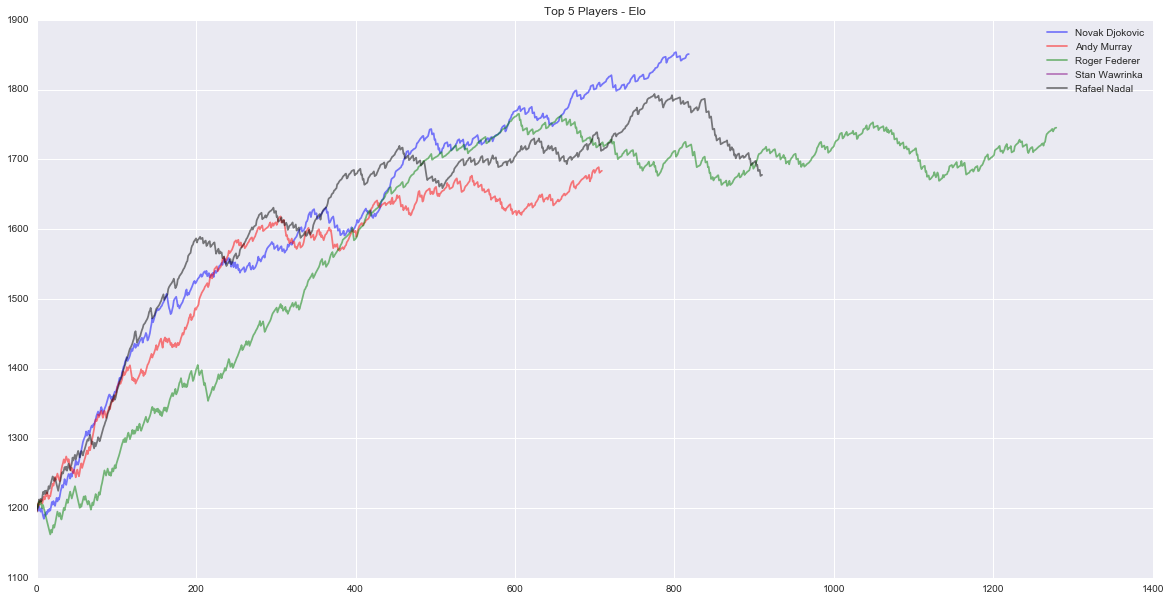

In [157]:
plt.figure(figsize=(20,10))
plt.plot(top5elo[top5[0]], color='blue', alpha=0.5)
plt.plot(top5elo[top5[1]], color='red',  alpha=0.5)
plt.plot(top5elo[top5[2]], color='green',  alpha=0.5)
plt.plot(top5elo[top5[3]], color='purple',  alpha=0.5)
plt.plot(top5elo[top5[4]], color='black',  alpha=0.5)
plt.title('Top 5 Players - Elo')
plt.legend(top5)
plt.show()

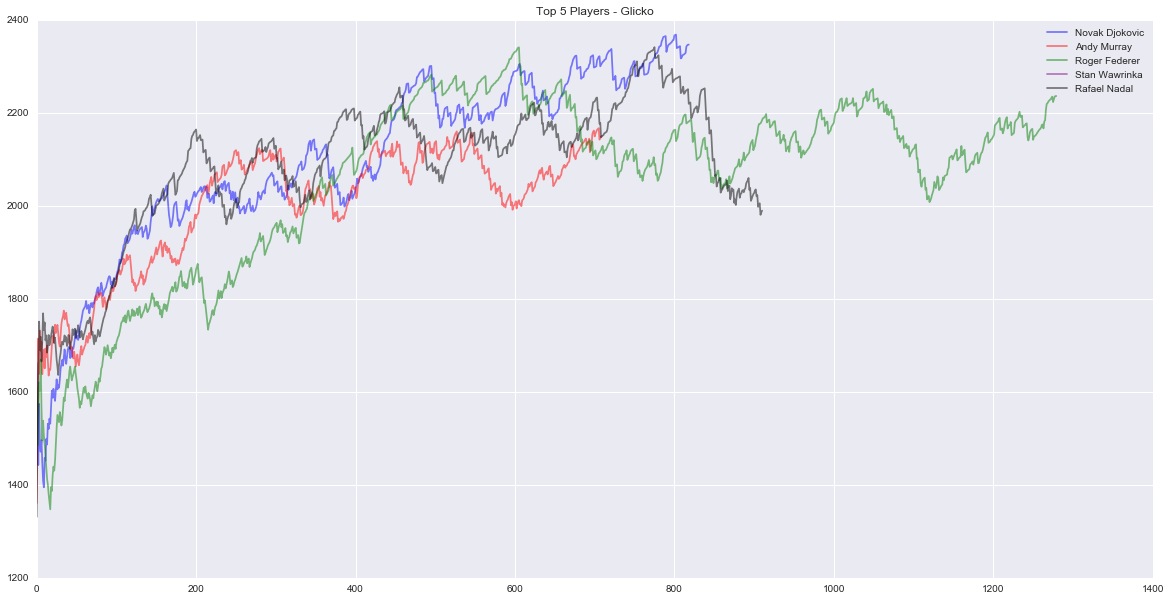

In [158]:
plt.figure(figsize=(20,10))
plt.plot(top5glicko[top5[0]], color='blue', alpha=0.5)
plt.plot(top5glicko[top5[1]], color='red',  alpha=0.5)
plt.plot(top5glicko[top5[2]], color='green',  alpha=0.5)
plt.plot(top5glicko[top5[3]], color='purple',  alpha=0.5)
plt.plot(top5glicko[top5[4]], color='black',  alpha=0.5)
plt.title('Top 5 Players - Glicko')
plt.legend(top5)
plt.show()

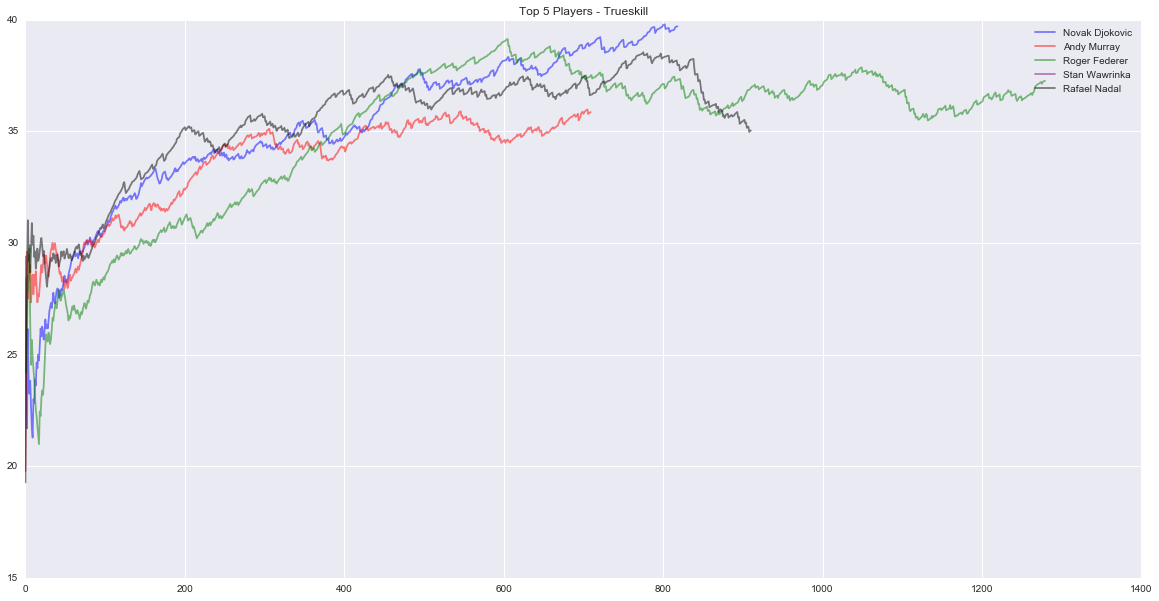

In [159]:
plt.figure(figsize=(20,10))
plt.plot(top5ts[top5[0]], color='blue', alpha=0.5)
plt.plot(top5ts[top5[1]], color='red',  alpha=0.5)
plt.plot(top5ts[top5[2]], color='green',  alpha=0.5)
plt.plot(top5ts[top5[3]], color='purple',  alpha=0.5)
plt.plot(top5ts[top5[4]], color='black',  alpha=0.5)
plt.title('Top 5 Players - Trueskill')
plt.legend(top5)
plt.show()

# Prediction

In [ ]:
atp_all_matches_backup = atp_all_matches.copy()
# should be (50963, 91)

## Creates Duplicate Rows to have the right encoding for our response
See discussion here: http://stats.stackexchange.com/questions/11800/how-should-we-convert-sports-results-data-to-perform-a-valid-logistical-regressi.  Necessary for symmetry.

In [ ]:
# CAN ONLY BE RUN ONCE
duplicate_matches = atp_all_matches.copy()
duplicate_matches['reversed'] = 1
duplicate_matches['diff_elo'] = -duplicate_matches.diff_elo.values
duplicate_matches['diff_glicko2'] = -duplicate_matches.diff_glicko2.values
duplicate_matches['diff_ts'] = -duplicate_matches.diff_ts.values
duplicate_matches['diff_rank'] = -duplicate_matches.diff_rank
duplicate_matches['h2h_all_diff'] = -duplicate_matches.h2h_all_diff
duplicate_matches['h2h_recent_diff'] = -duplicate_matches.h2h_recent_diff
duplicate_matches['player1_wins'] = 0


frame = [atp_all_matches, duplicate_matches]
combined = pd.concat(frame, ignore_index = True)
atp_all_matches = combined


### Our predictor columns

In [79]:
# create list of feature columns
cols = ['mean_elo', 'diff_elo', 'mean_ts', 'diff_ts', 'mean_glicko2', 'diff_glicko2', 'mean_rank', 'diff_rank', 'h2h_all_diff', 'h2h_recent_diff',
       'p1_top10', 'p2_top10', 'p1_h2h_prop', 'p2_h2h_prop', 'h2h_all_count']
others = cols[6:]

eloCols = cols[0:2]
tsCols = cols[2:4]
glickoCols = cols[4:6]

for col in others:
    eloCols.append(col)
    tsCols.append(col)
    glickoCols.append(col)
print eloCols

['mean_elo', 'diff_elo', 'mean_rank', 'diff_rank', 'h2h_all_diff', 'h2h_recent_diff', 'p1_top10', 'p2_top10', 'p1_h2h_prop', 'p2_h2h_prop', 'h2h_all_count']


In [ ]:
atp_all_matches.shape

In [ ]:
atp_all_matches.to_csv('jacobsdf.csv')

## Be sure to run the code in "Important Functions" in the Last Cell of the notebook

### Cross-Validation using each of the rating systems separately

In [162]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(atp_all_matches.shape[0]), train_size=0.7)

mask=np.ones(atp_all_matches.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

Xmatrix=atp_all_matches[cols]
yresp=atp_all_matches['player1_wins']

Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=yresp[mask]
ytest=yresp[~mask]

In [163]:
clflogELO, Xtrain, ytrain, Xtest, ytest = do_classify(clf=linear_model.LogisticRegression(fit_intercept = False),\
                                                   parameters = None, \
                                                   indf=atp_all_matches, featurenames=eloCols, targetname = 'player1_wins', \
                                                   target1val = 1, mask = mask)

clflogTS, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(clf=linear_model.LogisticRegression(fit_intercept = False),\
                                                   parameters = None, \
                                                   indf=atp_all_matches, featurenames=tsCols, targetname = 'player1_wins', \
                                                   target1val = 1, mask = mask)

clflogGLICKO, Xtrain2, ytrain2, Xtest2, ytest2 = do_classify(clf=linear_model.LogisticRegression(fit_intercept = False),\
                                                   parameters = None, \
                                                   indf=atp_all_matches, featurenames=glickoCols, targetname = 'player1_wins', \
                                                   target1val = 1, mask = mask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.63
[[ 8424  6879]
 [ 4526 10749]]
########################################################
using mask
############# based on standard predict ################
Accuracy on training data: 0.58
Accuracy on test data:     0.58
[[ 6653  8650]
 [ 4165 11110]]
########################################################
using mask
############# based on standard predict ################
Accuracy on training data: 0.59
Accuracy on test data:     0.59
[[ 7309  7994]
 [ 4601 10674]]
########################################################


/Users/dionhagan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


## Using Stacked Regression

In [36]:
itrain, intermediate_set = train_test_split(xrange(atp_all_matches.shape[0]), train_size=0.6, test_size=0.4)
icv, itest = train_test_split(intermediate_set, train_size=0.5, test_size=0.5)

mask=np.ones(atp_all_matches.shape[0], dtype='int')
mask[itrain]= 2
mask[icv] = 1
mask[itest]=0
cols = ['mean_elo', 'diff_elo', 'mean_ts', 'diff_ts', 'mean_glicko2', 'diff_glicko2']

Xmatrix=atp_all_matches[cols]
yresp=atp_all_matches['player1_wins']

Xtrain=Xmatrix[(mask == 2)]
Xcv = Xmatrix[(mask == 1)]
Xtest=Xmatrix[mask == 0]
ytrain=yresp[(mask == 2)]
ycv = yresp[(mask == 1)]
ytest=yresp[(mask == 0)]

## Fit each individual rating model separately

In [37]:
Ztrain = Xtrain[['mean_elo', 'diff_elo']]
Zcv = Xcv[['mean_elo', 'diff_elo']]
lm2cv = linear_model.LogisticRegression(fit_intercept = False).fit(Ztrain, ytrain)
lm2test =  linear_model.LogisticRegression(fit_intercept = False).fit(Ztrain, ytrain)

y = lm2cv.coef_.tolist()
x2 = pd.DataFrame(zip(Ztrain.columns, sum(y, [])), columns = ['features', 'estimatedCoefficients'])

training_accuracy = lm2cv.score(Ztrain, ytrain)
cv_accuracy = lm2cv.score(Zcv, ycv)
print "############# based on ELO COEFFS ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on cv data:     %0.2f" % (cv_accuracy)
print confusion_matrix(ycv, lm2cv.predict(Zcv))
print "########################################################"
print lm2cv.coef_

Wtrain = Xtrain[['mean_ts', 'diff_ts']]
Wcv = Xcv[['mean_ts', 'diff_ts']]
lm3cv = linear_model.LogisticRegression(fit_intercept = False).fit(Ztrain, ytrain)
lm3test = linear_model.LogisticRegression(fit_intercept = False).fit(Ztrain, ytrain)
y = lm3cv.coef_.tolist()
x3 = pd.DataFrame(zip(Wtrain.columns, sum(y, [])), columns = ['features', 'estimatedCoefficients'])

training_accuracy = lm3cv.score(Wtrain, ytrain)
cv_accuracy = lm3cv.score(Wcv, ycv)
print "############# based on TS COEFFS ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on cv data:     %0.2f" % (cv_accuracy)
print confusion_matrix(ycv, lm3cv.predict(Wcv))
print "########################################################"
print lm3cv.coef_

Gtrain = Xtrain[['mean_glicko2', 'diff_glicko2']]
Gcv = Xcv[['mean_glicko2', 'diff_glicko2']]
lm4cv = linear_model.LogisticRegression(fit_intercept = False).fit(Gtrain, ytrain)
lm4test = linear_model.LogisticRegression(fit_intercept = False).fit(Gtrain, ytrain)
y = lm4cv.coef_.tolist()
x4 = pd.DataFrame(zip(Gtrain.columns, sum(y, [])), columns = ['features', 'estimatedCoefficients'])

training_accuracy = lm4cv.score(Gtrain, ytrain)
cv_accuracy = lm4cv.score(Gcv, ycv)
print "############# based on GLICKO2 COEFFS ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on cv data:     %0.2f" % (cv_accuracy)
print confusion_matrix(ycv, lm4cv.predict(Gcv))
print "########################################################"
print y


############# based on ELO COEFFS ################
Accuracy on training data: 0.65
Accuracy on cv data:     0.65
[[6578 3637]
 [3487 6683]]
########################################################
[[  5.12014028e-06   6.74210883e-03]]
############# based on TS COEFFS ################
Accuracy on training data: 0.65
Accuracy on cv data:     0.66
[[6651 3564]
 [3468 6702]]
########################################################
[[  5.12014028e-06   6.74210883e-03]]
############# based on GLICKO2 COEFFS ################
Accuracy on training data: 0.66
Accuracy on cv data:     0.66
[[6736 3479]
 [3392 6778]]
########################################################
[[4.07954597664712e-06, 0.004272655905636718]]


## Regress on their predictions

In [38]:
predictions = {}
predictions_valid={}
predictions_valid['elo'] = lm2cv.predict_proba(Xcv[cols[0:2]])[:,0]
predictions_valid['ts'] = lm3cv.predict_proba(Xcv[cols[2:4]])[:,0]
predictions_valid['glicko'] = lm4cv.predict_proba(Xcv[cols[4:6]])[:,0]

dfensemble=pd.DataFrame.from_dict({'elo':predictions_valid['elo'],
                                   'ts':predictions_valid['ts'], 
                                   'glicko':predictions_valid['glicko'], 'y': ycv})

valreg = linear_model.LinearRegression()
valreg.fit(dfensemble[['elo','ts', 'glicko']], dfensemble['y'])

predictions['elo'] = lm2test.predict_proba(Xtest[cols[0:2]])[:,0]
predictions['ts'] = lm2test.predict_proba(Xtest[cols[2:4]])[:,0]
predictions['glicko'] = lm2test.predict_proba(Xtest[cols[4:6]])[:,0]


dfensembletest = pd.DataFrame.from_dict({'elo':predictions['elo'],
                                   'ts':predictions['ts'], 
                                   'glicko':predictions['glicko'], 'y':ytest})
epreds = valreg.predict(dfensembletest[['elo','ts', 'glicko']])
testactual = dfensembletest['y'].values

training_accuracy = valreg.score(dfensemble[['elo', 'ts', 'glicko']], dfensemble['y'])
print training_accuracy
predicted_outcome = [1 if x > 0.5 else 0 for x in epreds]
confuse = confusion_matrix(testactual, predicted_outcome)
print confuse
testing_accuracy = (confuse[0,0] + confuse[1,1])/(confuse[0,0]+confuse[0,1]+confuse[1,0]+confuse[1,1])
print testing_accuracy
#print (6694+6725)/(6660+6725 + 3493+3507)


0.157482958674
[[6722 3574]
 [3406 6684]]
0.657608162464


In [80]:
len(cols)

15

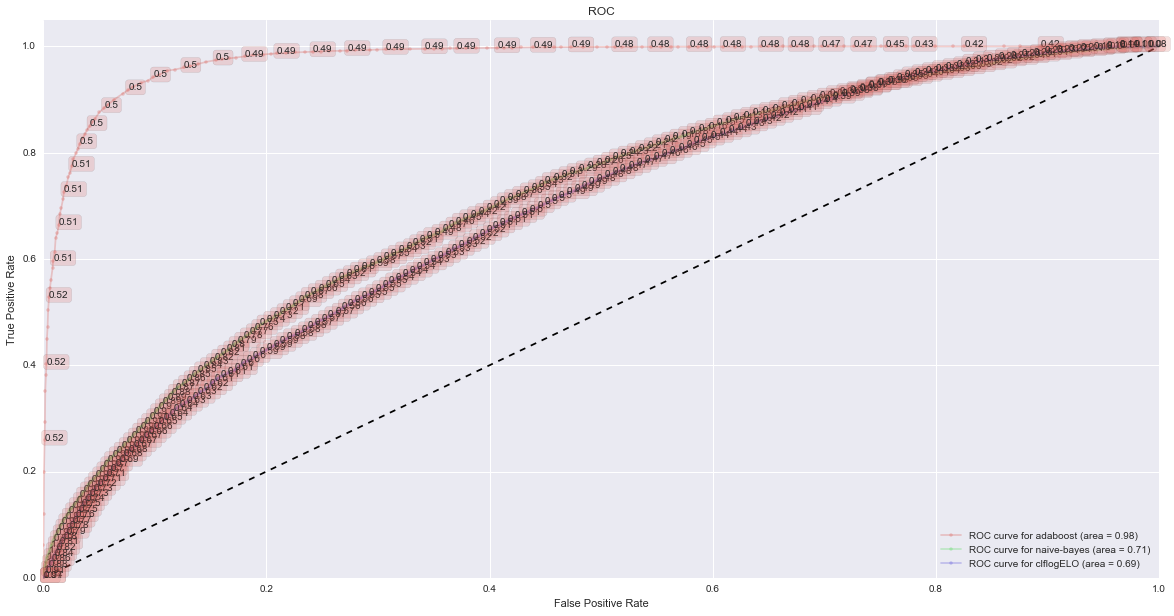

In [175]:
with sns.color_palette("hls", 3):
    plt.figure(figsize=(20,10))
    ax = make_roc("adaboost", clfAda, ytesta, Xtesta, labe=200, skip=50)
    ax = make_roc("naive-bayes", clfNB, yte, Xte, labe=200, skip=50, ax = ax, proba = True)
    ax = make_roc("clflogELO", clflogELO, ytest, Xtest, labe=200, skip=50, ax = ax, proba = True)
    plt.show()

### Logistic Regression

Probability player 1 wins = ? given (for example) head-head, clay player or not, surface, momentum, grandslam, grandslam_player, relative elo, etc.

### Naive Bayes

In [90]:
X=atp_all_matches[cols].values
y=atp_all_matches.player1_wins.values
from sklearn.naive_bayes import GaussianNB
clfNB=GaussianNB()
itr,ite=train_test_split(xrange(atp_all_matches.shape[0]), train_size=0.7)
Xtr=X[itr]
Xte=X[ite]
ytr=y[itr]
yte=y[ite]
clfNB.fit(Xtr,ytr)
test_acc = 1 - float((yte != clfNB.predict(Xte)).sum())/yte.shape[0]
print "Testing Accuracy: %.02f" % test_acc
confusion_matrix(clfNB.predict(Xte),yte)

Testing Accuracy: 0.65


array([[10104,  5452],
       [ 5300,  9722]])

### Adaboost

In [176]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtraina, ytraina, Xtesta, ytesta = do_classify(clfAda, parameters, 
                                                       indf=atp_all_matches, 
                                                       featurenames=cols, targetname='player1_wins', target1val = 1, mask=mask, 
                                                       score_func='f1', n_jobs=4)


using mask


/Users/dionhagan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 58} 0.910105397208 [mean: 0.89125, std: 0.05470, params: {'n_estimators': 10}, mean: 0.89416, std: 0.05405, params: {'n_estimators': 11}, mean: 0.89276, std: 0.05391, params: {'n_estimators': 12}, mean: 0.88839, std: 0.05179, params: {'n_estimators': 13}, mean: 0.89165, std: 0.05333, params: {'n_estimators': 14}, mean: 0.89229, std: 0.05239, params: {'n_estimators': 15}, mean: 0.89213, std: 0.04886, params: {'n_estimators': 16}, mean: 0.89305, std: 0.05424, params: {'n_estimators': 17}, mean: 0.89305, std: 0.05337, params: {'n_estimators': 18}, mean: 0.89348, std: 0.05316, params: {'n_estimators': 19}, mean: 0.89528, std: 0.05424, params: {'n_estimators': 20}, mean: 0.89370, std: 0.05407, params: {'n_estimators': 21}, mean: 0.89639, std: 0.05620, params: {'n_estimators': 22}, mean: 0.89757, std: 0.05214, params: {'n_estimators': 23}, mean: 0.89661, std: 0.05727, params: {'n_estimators': 24}, mean: 0.89766, std: 0.05269, params: {'n_estimators': 25}, mean: 0.90005,

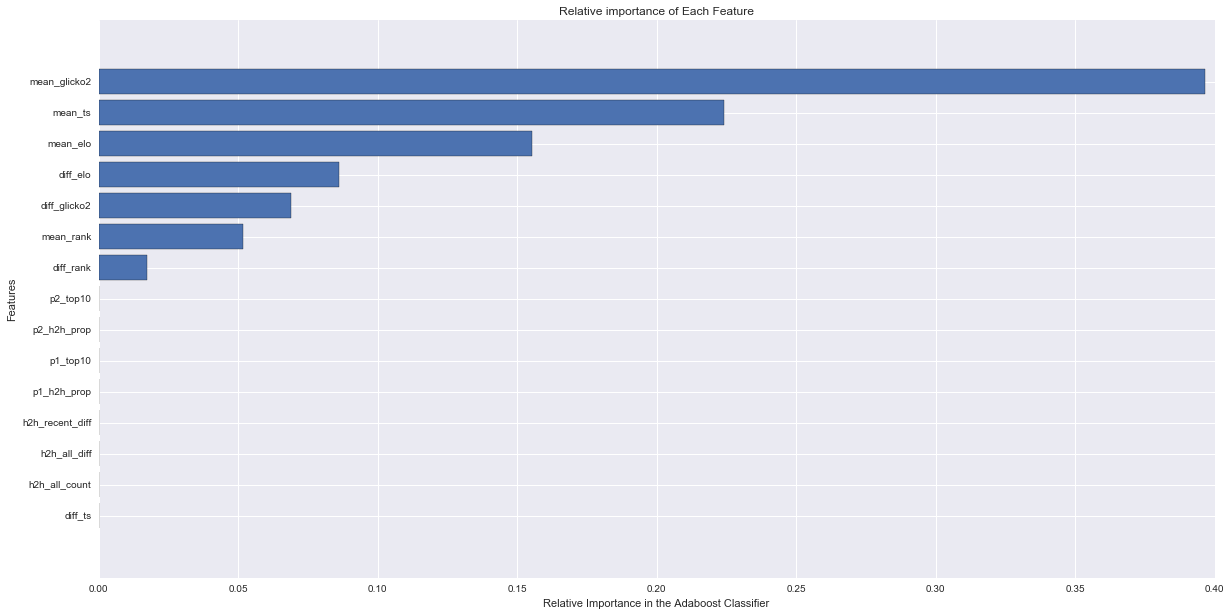

In [167]:
importance_list = clfAda.feature_importances_
name_list = cols
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20, 10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Adaboost Classifier')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

## IMPORTANT HELPER FUNCTIONS

In [57]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

## Point-by-Point Probability Model

See pbp_probability_model.ipynb.